## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, TPABC, SMCABC, SMC2ABC, SNLABC, SNL2ABC
import distributions 
import scipy.stats as stats

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

In [56]:
from problems.ABC_problems import ABC_Problem

class Neuronal_Problem(ABC_Problem):
    
    def __init__(self, data, N=100, n=100):
        
        assert N <= data['Y'].shape[0]
        assert data['Y'].ndim == 2
        assert data['X'].shape[0] == data['Y'].shape[0]
        
        self.N = N # number of posterior samples
        self.n = n # length of the data vector x = {x_1, ..., x_n} # makes sense to make it ~num_trials
#         self.d = 5 # this argument is ignored... set hidden_ratio instead. most likely it's dims of sufficient statistics: d=2K
        self.prior_args = np.array([[0,1]]) # these are bounds on theta (on X in our case: [0,1])
        
        self.all_thetas = data['X']
        self.sim_accuracy = 5 # number of digits after a decimal point for theta
        self.sim = {np.round(data['X'][i],self.sim_accuracy): data['Y'][i] for i in range(data['X'].shape[0])} #here we use all!
        self.K = 1 # number of thetas
        self.stat = 'raw' # raw means that sufficient statistics is unknown (I guess). y_obs = data_obs
        
        self.data_obs = data['Y'] #important that first dim=N & y_dim = product of these dims
        # y_obs is calculated from these data as y=statistics(data). 
        # note that y_obs is a argument of a Algorithm class, not Problem (¯\_(ツ)_/¯)
        
        self.is_batch_sampling_supported = False # (unfinished feature, so keep False for now) speed up rejection sampling
    
    def get_true_theta(self):
        pass # does not matter, as the result goes into 'statistics', where theta is currently not used

    def sample_from_prior(self, size=1):
        return np.random.choice(self.all_thetas,size=size,replace=True) # just 1 sample
    
    # original code samples only 1 theta in each simulation -> generates n x-es -> 
    # calculates statistics for them (1 vector for 1 theta) -> repeats ~1000 times sequentially (!)
    def simulator(self, theta):
        assert theta.size==1 # input = array with 1 element
        y = np.empty((self.n,self.data_obs.shape[1])) 
        for i in range(self.n): 
            t = np.round(theta[0] + (np.random.rand()-0.5)*0.002,self.sim_accuracy) # add jitter, to sample from the neighbouring locations
            if t in self.sim:
                y[i] = self.sim[t]
            else: # this part is used for newly-generated samples; let's take the Y=Y(closest X).
                discr = np.min(np.array([1-np.abs(self.all_thetas - t),np.abs(self.all_thetas - t)])%1,axis=0) # get distances
                y[i] = self.sim[np.round(self.all_thetas[np.argmin(discr)],self.sim_accuracy)] # take the closest
        return y # self.n x number of dimensions in data

    # B. correlation between latent
    def _ss_corr(self, Z):
        V = np.mat(Z).T * np.mat(Z) / Z.shape[0]
        (d,d) = V.shape
        upper_tri_elements = V[np.triu_indices(d, k=1)]
        stat = np.array(upper_tri_elements)
        return stat
    
    def statistics(self, data, theta=None):
        if self.stat == 'raw':
            # (correlation) as summary statistics (NO MARGINALS in these data)
            stat = self._ss_corr(data)
            return stat
        else:
            raise NotImplementedError('No ground truth statistics')

In [57]:
import pickle as pkl
with open(f'/home/nina/CopulaGP/plos_fig5_data/ST260_Day1_Dataset.pkl',"rb") as f:
    data = pkl.load(f)
    
Nvar = 109 # taking the first N variables here
data['Y'] = data['Y'][:,:Nvar] 
print(data['Y'].shape) # samples x neuronal/behavioral variables
    
problem = Neuronal_Problem(data)

DIR = 'results/Neuronal' 

(21471, 109)


In [58]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:0'
hyperparams.num_sim = 1000                        # number of simulations
hyperparams.L = 5                                # number of learning rounds
hyperparams.hidden_ratio = 0.001                 # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x), use CNN here
hyperparams.estimator = 'DV'                    # MI estimator; JSD or DC, see the paper
# 'DV' = proper MINE from Belghazi 2018
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1) # looks like D here is in fact K

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)


In [59]:
snl2_abc.run()


iteration  0
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  10
[ABC] sub-process start!
[sampling] finished sampling  20
[ABC] sub-process start!
[sampling] finished sampling  30
[sampling] finished sampling  40

 > fitting encoder
summary statistic dim = 5 original dim = 5886
architecture [5886, 100, 100, 5]
validation size= 0.8
finished: t= 0 loss= 1.576542854309082e-05 loss val= 2.1457672119140625e-05 time= 0.07285737991333008
finished: t= 50 loss= 3.933906555175781e-06 loss val= 1.9632279872894287e-05 time= 0.05890822410583496
finished: t= 100 loss= 1.4156103134155273e-07 loss val= 2.2351741790771484e-07 time= 0.062307119369506836
finished: t= 150 loss= 4.470348358154297e-08 loss val= 1.6391277313232422e-07 time= 0.06525778770446777
finished: t= 200 loss= -5.21540641784668e-08 loss val= 1.9371509552001953e-07 time= 0.05819964408874512
best val loss= -7.428228855133057e-06

 > fitting nde
all_stats.size() torch.Size([200, 5])
finished:

finished: t= 1000 loss= -1.625431776046753 loss val= -1.1798820495605469 time= 0.0812300443649292
finished: t= 1050 loss= -1.5976455211639404 loss val= -1.2111144065856934 time= 0.08568179607391357
finished: t= 1100 loss= -1.8130019903182983 loss val= -0.9340564012527466 time= 0.08510279655456543
finished: t= 1150 loss= -1.788983941078186 loss val= -1.2046327590942383 time= 0.08528733253479004
finished: t= 1200 loss= -1.6441895961761475 loss val= -1.1753109693527222 time= 0.08382773399353027
finished: t= 1250 loss= -1.6988707780838013 loss val= -1.0835063457489014 time= 0.08464884757995605
finished: t= 1300 loss= -1.7344543933868408 loss val= -1.0835919380187988 time= 0.08320879936218262
finished: t= 1350 loss= -1.8487274646759033 loss val= -1.1159909963607788 time= 0.08289468288421631
finished: t= 1400 loss= -1.9092693328857422 loss val= -1.1689887046813965 time= 0.08075976371765137
finished: t= 1450 loss= -1.9799665212631226 loss val= -1.1177263259887695 time= 0.0798635482788086
fini

finished: t= 2500 loss= -2.3657569885253906 loss val= -1.643078327178955 time= 0.12020689249038696
finished: t= 2550 loss= -2.2651889324188232 loss val= -1.311786413192749 time= 0.077434241771698
finished: t= 2600 loss= -2.3517260551452637 loss val= -1.3370916843414307 time= 0.076385498046875
finished: t= 2650 loss= -2.4423012733459473 loss val= -1.6632046699523926 time= 0.07746583223342896
finished: t= 2700 loss= -2.1290454864501953 loss val= -1.665994644165039 time= 0.07892131805419922
finished: t= 2750 loss= -1.8750003576278687 loss val= -1.681931734085083 time= 0.07997357845306396
best val loss= -1.6826225519180298

 > fitting nde
all_stats.size() torch.Size([1000, 5])
finished: t= 0 loss= 8.54290771484375 loss val= 8.278451919555664
finished: t= 500 loss= -6.822996139526367 loss val= -6.485517978668213
best val loss= -6.63377046585083

 > fitting proposal
mu= [[0.65389861]]
cov= [[0.00137138]]




(array([ 17.,  52.,  95., 191., 220., 227., 134.,  39.,  16.,   9.]),
 array([0.54362315, 0.56798066, 0.59233817, 0.61669568, 0.64105319,
        0.6654107 , 0.68976821, 0.71412572, 0.73848323, 0.76284074,
        0.78719825]),
 <a list of 10 Patch objects>)

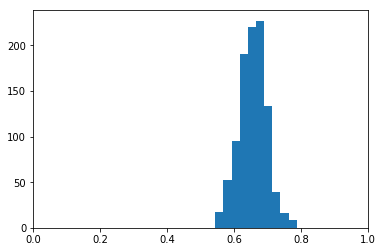

In [60]:
# let us check that the prior did not collapse 
theta = np.empty(1000)
for i in range(len(theta)): 
    theta[i] = snl2_abc.prior()
plt.xlim([0,1])
plt.hist(theta)

In [202]:
# visualize latents s(x)
nbins=100
stats2plot = []
data2plot = []
summary2plot = []
for i in range(nbins):
    mask = (data['X']>i/nbins) & (data['X']<=(i+1)/nbins)
    get_stat = snl2_abc.convert_stat(snl2_abc.problem.statistics(data['Y'][mask]))
    stats2plot.append(get_stat)
    data2plot.append(data['Y'][mask].mean(0))
    summary2plot.append(snl2_abc.problem.statistics(data['Y'][mask]))
# np.array(stats2plot).shape
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA
latent_PCA = PCA(n_components=2).fit_transform(np.array(stats2plot).squeeze())
latent_TSNE = TSNE(n_components=2).fit_transform(np.array(stats2plot).squeeze())
latent_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(stats2plot).squeeze())


summary_PCA = PCA(n_components=2).fit_transform(np.array(summary2plot).squeeze())
summary_TSNE = TSNE(n_components=2).fit_transform(np.array(summary2plot).squeeze())
summary_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(summary2plot).squeeze())


data_PCA = PCA(n_components=2).fit_transform(np.array(data2plot).squeeze())
data_TSNE = TSNE(n_components=2).fit_transform(np.array(data2plot).squeeze())
data_LEM = SpectralEmbedding(n_components=2).fit_transform(np.array(data2plot).squeeze())

# latent_TSNE = TSNE(n_components=2).fit_transform(np.array(stats2plot).squeeze())



Text(0.32,0.26,'Binned data')

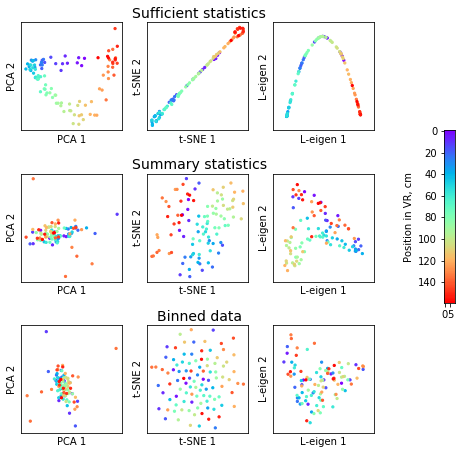

In [219]:
import matplotlib.cm as cm
fig = plt.figure(figsize=(7,6))

# fig.add_axes([0,0,1,1])


ax = [fig.add_axes([0.05,0,0.2,0.25]),
      fig.add_axes([0.3,0,0.2,0.25]),
      fig.add_axes([0.55,0,0.2,0.25]),
     fig.add_axes([0.05,0.35,0.2,0.25]),
     fig.add_axes([0.3,0.35,0.2,0.25]),
      fig.add_axes([0.55,0.35,0.2,0.25]),
     fig.add_axes([0.05,0.7,0.2,0.25]),
     fig.add_axes([0.3,0.7,0.2,0.25]),
      fig.add_axes([0.55,0.7,0.2,0.25]),
     fig.add_axes([0.85,0.3,0.1,0.4]),]

ax[0].scatter(*data_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[1].scatter(*data_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[2].scatter(*data_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

ax[3].scatter(*summary_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[4].scatter(*summary_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[5].scatter(*summary_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

ax[6].scatter(*latent_PCA.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[7].scatter(*latent_TSNE.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)
ax[8].scatter(*latent_LEM.T,color=cm.rainbow(np.linspace(0,1,nbins)),s=5)

for a in [ax[0],ax[3],ax[6]]:
    a.set_xlabel('PCA 1')
    a.set_ylabel('PCA 2')
    
for a in [ax[1],ax[4],ax[7]]:
    a.set_xlabel('t-SNE 1')
    a.set_ylabel('t-SNE 2')
    
for a in [ax[2],ax[5],ax[8]]:
    a.set_xlabel('L-eigen 1')
    a.set_ylabel('L-eigen 2')
    
for a in ax[:-1]:
    a.set_xticks([])
    a.set_yticks([])
    
ax[9].imshow(np.repeat(np.linspace(0,1,160).reshape(1,-1),10,axis=0).T,cmap=cm.rainbow)
ax[9].set_ylabel("Position in VR, cm")

fig.text(0.27,0.96,'Sufficient statistics',fontsize=14)
fig.text(0.27,0.61,'Summary statistics',fontsize=14)
fig.text(0.32,0.26,'Binned data',fontsize=14)

# help(plt.imshow)
# plt.scatter(*X_embedded[int(nbins*20/160):int(nbins*60/160)].T,marker='x',color='k') #late part of the corridor marked

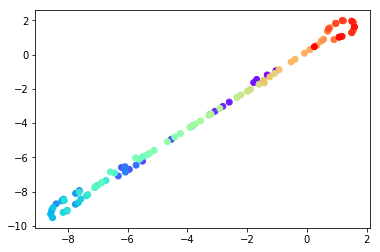

In [135]:
import matplotlib.cm as cm
plt.scatter(*X_embedded.T,color=cm.rainbow(np.linspace(0,1,nbins)))
# plt.scatter(*X_embedded[int(nbins*20/160):int(nbins*60/160)].T,marker='x',color='k') #late part of the corridor marked

In [172]:
# calculate MI using all generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[0:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[0:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

torch.Size([1000, 1])


tensor(2.3482, grad_fn=<SubBackward0>)

In [173]:
# calculate MI using the last generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[snl2_abc.l:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[snl2_abc.l:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100) # n here is the number of shuffles

torch.Size([200, 1])


tensor(2.3747, grad_fn=<SubBackward0>)

In [221]:
2.37/np.log(2)

3.4191872469068434

# MINE for comparison

In [175]:
from mine import train_MINE # load another implementation, the one I used for PLoS

In [201]:
train_MINE(data['Y'][:,:Nvar], x=torch.tensor(data['X'][:]).float(), 
           H=500, lr=0.01, batches=1, n_epoch=2000, device = torch.device("cuda:0"))

array(0.88089633, dtype=float32)

In [222]:
0.88/np.log(2)

1.269571635982288